In [1]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
import copy
import cv2
import scipy
from skimage.feature import peak_local_max
from torchvision import transforms
import pickle
from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import solve_ivp
device = torch.device('cpu')

In [12]:
%run Supporting_Function.py
%run ODE_Func.py
%run Ploting_Function_Fly.py
%run GaussianFunc_noGrad.py
%run GaussianFunc_full.py
%run GaussianFunc_ChevMetric.py

In [11]:
class my_round_func(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [13]:
#@title Extract Data 

infile = open('Gap_genes_2dspace_flow_2xbcd.obj','rb')
H1, H2, H1dot, H2dot = pickle.load(infile)
infile.close()

Hdot = np.ma.stack([H1dot, H2dot], 2)
H_coord = np.ma.stack([H1, H2], 2)

V1, N1 = extractData(H1dot, H1)
V2, N2 = extractData(H2dot, H2)

N = np.concatenate((N1, N2), 1)
V = np.concatenate((V1, V2), 1)

N = torch.from_numpy(N).float()
V = torch.from_numpy(V).float()

V_norm = (V-torch.mean(V))/torch.std(V)

In [ ]:
fig, axs = plt.subplots(5, 2)
fig.set_figheight(25)
fig.set_figwidth(10)
i = j = 0
for file in os.listdir():
    if file.endswith(".obj"):
        print(file.title())
        infile = open(file.title(),'rb')
        H1, H2, H1dot, H2dot = pickle.load(infile)
        infile.close()

        Hdot = np.ma.stack([H1dot, H2dot], 2)
        H_coord = np.ma.stack([H1, H2], 2)

        V1, N1 = extractData(H1dot, H1)
        V2, N2 = extractData(H2dot, H2)

        N = np.concatenate((N1, N2), 1)
        V = np.concatenate((V1, V2), 1)

        N = torch.from_numpy(N).float()
        V = torch.from_numpy(V).float()

        V_norm = (V-torch.mean(V))/torch.std(V)
        if j ==5:
            i += 1
            j = 0
        axs[j,i].streamplot(H1, H2, H1dot, H2dot, density=2)
        axs[j,i].set_title(file.title())
        j += 1

fig.savefig('temp.png', dpi=fig.dpi)

In [33]:
param_M = {'nhidden_M' : 16, 'nlayer_M' : 1}
param_V = {'nhidden_P' : 2, 'n_V' : 32}
param_C = {'n_fc1' : 8 , 'n_fc2' : 16}  

func = GaussianFunc_DualMetric(2, param_M, param_V, param_C)
lr = 0.01
N_grad = N.detach().requires_grad_(True)
params = list(func.parameters())
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
pred_steps = 500
OldParams = None
min_loss = np.inf

In [34]:
try:
    for itr in range(1, 10**6):
        optimizer.zero_grad()
        pred = func(N_grad)
        loss = ((pred - V_norm)**2).sum()/pred.shape[0]
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        display.clear_output()
        print('Iter: {}, MSE loss: {:.4f}'.format(itr, -loss_meter.avg))
    
        if loss_meter.avg < min_loss:
          torch.save(func, 'min_func_Fly.pt')
          min_loss = loss_meter.avg
          print("min model_updated")

except KeyboardInterrupt:

    print('Training complete after {} iters.'.format(itr))

Iter: 4133, MSE loss: -0.3981
min model_updated
Training complete after 4134 iters.


In [36]:
min_func = torch.load('min_func_Fly.pt')

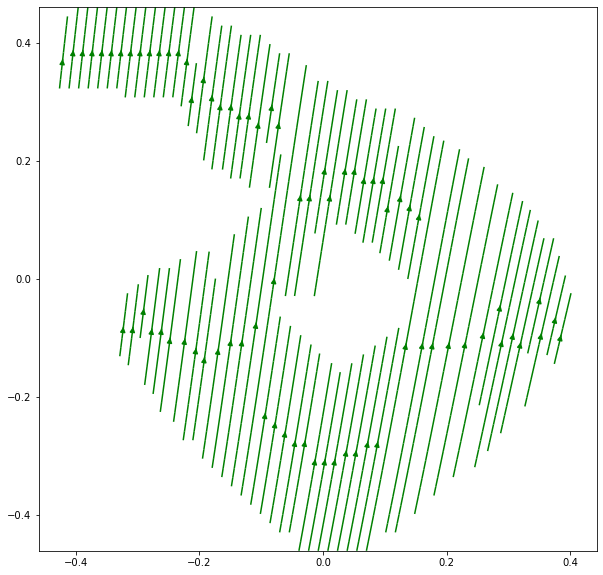

In [29]:
H1a, H2a = get_data_func_Fly(min_func.metric_nn, H1, H2, size = 100, ma = H1dot.mask)
plt.figure(figsize=[10,10])
plt.streamplot(H1, H2, H1a, H2a, density=2, color = 'g')
plt.show()

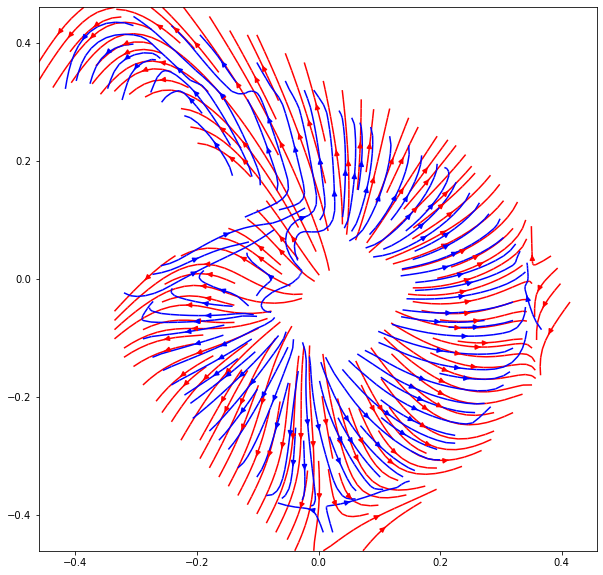

In [38]:
H1a, H2a = get_data_func_Fly(min_func, H1, H2, size = 100, ma = H1dot.mask)
plt.figure(figsize=[10,10])
plt.streamplot(H1, H2, H1a, H2a, density=2, color = 'r')
plt.streamplot(H1, H2, H1dot, H2dot, density=2, color = 'b')
plt.show()

In [ ]:
X = np.linspace(- 0.6, 0.6, 100)
h_mask = get_data_V_Fly(min_func, H1, H2, ma = H1dot.mask, num = None, flip = False, X = X)

x, y = np.meshgrid(X, X)
plt.figure(figsize = [10, 8])
plt.contourf(x, y, h_mask, cmap='Blues', )
plt.colorbar()
plt.show()

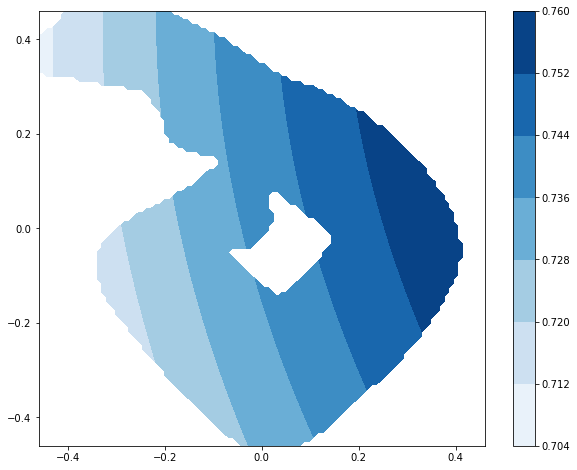

In [39]:
size = len(H1)
a = min_func.switch(torch.Tensor(np.stack([H1, H2], -1).reshape(size*size, 2)))
a = a.cpu().detach().numpy()
h = a.reshape(size,size)
h_mask = np.ma.masked_array(h, mask=H1dot.mask)

plt.figure(figsize = [10, 8])
plt.contourf(H1, H2, h_mask, cmap='Blues')
plt.colorbar()
plt.show()

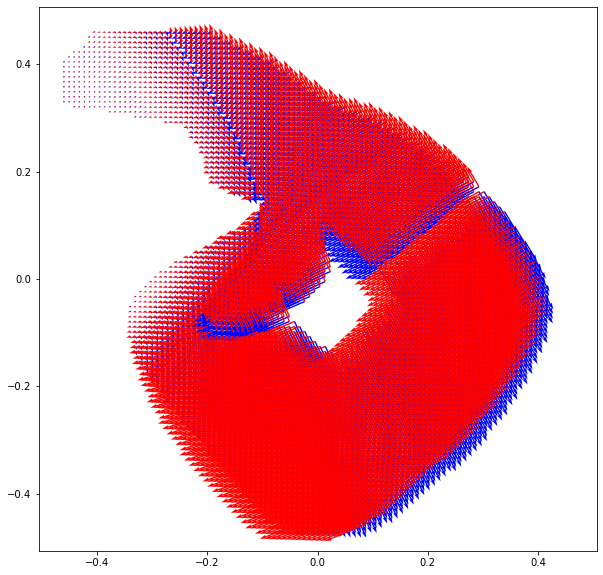

In [45]:
coord, eigvec1, eigvec2 = get_data_eig_Fly(min_func, H1, H2, erode_size = 1, eig_type = 'vector', ma = H1dot.mask)
sc = 10**-1
x, y = coord
u1, v1 = eigvec1
u2, v2 = eigvec2
plt.figure(figsize=[10,10])
plt.quiver(x,y,u1,v1, color= 'b',angles='xy', scale_units='xy', scale=1/sc)
plt.quiver(x,y,u2,v2, color='r',angles='xy', scale_units='xy', scale=1/sc)
plt.show()

In [32]:
class GaussianFunc_DualMetric(nn.Module):

  def __init__(self, dim = 2, param_M = {'nhidden_M' : 8, 'nlayer_M' : 1}, param_V = {'nhidden_P' : 8, 'n_V' : 2}, param_C = {'n_fc1' : 8 , 'n_fc2' : 16}):
    super(GaussianFunc_DualMetric, self).__init__()

    self.param_M = param_M
    self.param_V = param_V
    self.param_C = param_C

    nhidden_M = param_M['nhidden_M']
    nlayer_M = param_M['nlayer_M']
    nhidden_P = param_V['nhidden_P']

    n_fc1 = param_C['n_fc1']
    n_fc2 = param_C['n_fc2']

    self.n_V = param_V['n_V']
    self.ndim = dim
    self.potential_list = nn.ModuleList([])

    self.th = nn.Tanh() 
    self.sg = nn.Sigmoid()
    self.softplus = nn.Softplus(100)
    self.elu = nn.ELU(inplace = True)
    self.relu = nn.ReLU(inplace = True)

    self.metric_list = nn.ModuleList([nn.Linear(dim, nhidden_M)])
    for i in range(nlayer_M):
      self.metric_list.append(nn.Linear(nhidden_M, nhidden_M))
    self.metric_list.append(nn.Linear(nhidden_M, 2))

    # self.dout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(2, n_fc1)
    self.fc2 = nn.Linear(n_fc1, n_fc2)
    self.fc3 = nn.Linear(n_fc2, 1)
    self.batchnorm1 = nn.BatchNorm1d(n_fc1)
    self.batchnorm2 = nn.BatchNorm1d(1)
    self.custom_round = my_round_func.apply

    for i in range(self.n_V):
      self.potential_list.append(nn.Linear(dim, nhidden_P))
      self.potential_list.append(nn.Linear(nhidden_P, nhidden_P, bias = False))
      self.potential_list.append(nn.Linear(nhidden_P, 1, bias = False))

  def softSig(self, input):
    Amp = 0.3
    slope = 2
    output = 1 + torch.log(slope*self.softplus(input) + 1) + torch.tanh(-1*slope*self.softplus(-1*input))
    output = Amp*output
    return output

  def metric_nn(self, x):
    out = self.metric_list[0](x)
    out = self.elu(out)
    
    for i, nlayer in enumerate(self.metric_list[1:-1]):
      out = nlayer(out)
      out = self.elu(out)
    
    out = self.metric_list[-1](out)
    out = self.softSig(out)
    return out

  def switch(self, x):
    out = self.elu(self.fc1(x))
    out = self.elu(self.fc2(out))

    out = self.fc3(out)
    out = self.sg(out)
    return out

  def metric(self, x):
    temp_dim = self.metric_nn(x).shape

    eigval = self.metric_nn(x)
    Id = (torch.eye(2)).repeat(temp_dim[:-1] + (1,1))
    D = torch.mul(eigval.unsqueeze(1), Id)

    scale = self.switch(x)
    # scale = torch.ones(x.shape)
    P_1 = 0.5*torch.tensor([[-1, 1], [1, 1]]).float()
    P_1 = torch.mul(scale.unsqueeze(1), P_1)

    P_2 = torch.tensor([[1, 0], [0, 1]]).float()
    P_2 = torch.mul(1-scale.unsqueeze(1), P_2)
    
    P = P_1 + P_2
    P_inv = torch.inverse(P)

    PD = torch.matmul(P, D)
    PDP = torch.matmul(PD, P_inv)
    return PDP

  def potential(self, num, x, return_all= False):
    size = 3
    start = size*num
    end = size*(num+1)
    layers_V = self.potential_list[start:end]
    self.last_layers = layers_V

    out = layers_V[0](x)
    out = torch.pow(out, 2)
    out1 = out

    out = layers_V[1](out)
    out = torch.exp(out)
    out2 = out

    out = layers_V[-1](out)
    out3 = out

    if return_all:
      return out1, out2, out3 
    else:
      return out3

  def gradient(self, num, x):
    f1,f2,f3 = self.potential(num, x, True)
    layers_V = self.last_layers

    W3 = layers_V[-1].weight.data
    grad = W3

    W2 = layers_V[1].weight.data
    f2_prime = f2
    grad = torch.mm(grad*f2_prime, W2)

    W1 = layers_V[0].weight.data
    f1_prime = 2*layers_V[0](x)
    grad = torch.mm(grad*f1_prime, W1)
    return grad

  def total_grad(self, x):
    grad = self.gradient(0, x)
    for i in range(1,self.n_V):
      grad = grad + self.gradient(i, x)
    grad = grad/self.n_V
    return grad

  def total_V(self,x):
    out = self.potential(0,x)
    for i in range(1,self.n_V):
      out = out + self.potential(i,x)
    out = out/self.n_V
    return out

  def forward(self, x):
    grad = self.total_grad(x).unsqueeze(2)
    mag = self.metric(x)
    out = torch.matmul(mag, grad).squeeze()
    return out

In [24]:
x = N_grad
temp_dim = func.metric_nn(x).shape

eigval = func.metric_nn(x)
Id = (torch.eye(2)).repeat(temp_dim[:-1] + (1,1))
D = torch.mul(eigval.unsqueeze(1), Id)

scale = func.switch(x)
# scale = torch.ones(x.shape)
P_1 = 0.5*torch.tensor([[-1, 1], [1, 1]]).float()
P_1 = torch.mul(scale.unsqueeze(1), P_1)

P_2 = torch.tensor([[1, 0], [0, 1]]).float()
P_2 = torch.mul(1-scale.unsqueeze(1), P_2)

P = P_1 + P_2
P_inv = torch.inverse(P)

PD = torch.matmul(P_inv, D)
PDP = torch.matmul(PD, P)

In [20]:
torch.inverse(P)[1]

tensor([[10.9841, -4.0578],
        [-4.0578,  2.8685]], grad_fn=<SelectBackward>)

In [21]:
P[1]

tensor([[0.1907, 0.2698],
        [0.2698, 0.7302]], grad_fn=<SelectBackward>)

In [23]:
torch.matmul(torch.inverse(P)[1], P[1])

tensor([[1.0000e+00, 2.3842e-07],
        [0.0000e+00, 1.0000e+00]], grad_fn=<MmBackward>)